In [142]:
import math
import os
import networkx as nx
from itertools import combinations, groupby
import random
from networkx.algorithms import community
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import karateclub.graph_embedding.graph2vec as Graph2Vec
import karateclub.graph_embedding.feathergraph as Feather

from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import StandardScaler


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [116]:
def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G


In [117]:
def GenerateGraphData(n):

    probListMin=[
        0.00156, 
        0.00117,
        0.00092 ,
        0.00055,
        0.00055,
        0.00062,
        0.00050
    ]
    probListMax=[
        0.00234, 
        0.00146, 
        0.00110, 
        0.00110,
        0.00082,
        0.00067,
        0.00067
    ]

    label_list=[]
    Graph_list=[]

    for k in range(1,8):
        for i in range(n):
            nodeCount=random.randint(150*k,150*(k+1))*2
            G=gnp_random_connected_graph(nodeCount,random.uniform(probListMin[k-1],probListMax[k-1]))
            Partition=community.kernighan_lin.kernighan_lin_bisection(G,max_iter=int( (0.4*len(G.nodes())*math.log10(len(G.nodes())))) )
            Gs1=nx.subgraph(G,Partition[0])
            Gs2=nx.subgraph(G,Partition[1])
            if(nx.is_connected(Gs1) and nx.is_connected(Gs2) and len(Gs1.nodes()) <= (len(G.nodes())/2+len(G.nodes())*0.01) 
                    and len(Gs1.nodes()) >= (len(G.nodes())/2-len(G.nodes())*0.01)   ):
                label_list=[True]+label_list
                Graph_list=[G]+Graph_list
            else:
                label_list=label_list+[False]
                Graph_list=Graph_list+[G]
        
    graph_data= {
        "Graph": Graph_list,
        "Labels":label_list
    }

    return graph_data


In [173]:
N=400
GraphDataList=GenerateGraphData(N)
N=N*7
graphDataFrame= pd.DataFrame(GraphDataList)

In [174]:
fileName="GraphdataSmall.pickle"
abs_file_path = "C:/Users/Deniz/Desktop/TOBB/Yap470/Proje/GraphBipartationML/GraphDatas"
abs_file_path=abs_file_path+"/"+fileName


In [175]:
graphDataFrame.to_csv(fileName+".csv")
pickle.dump(graphDataFrame,open(abs_file_path,"wb"))

In [217]:

def FeatherEmbedding(d,X_train,X_test):
    Gmodel = Feather.FeatherGraph(d)
    Gmodel.fit(X_train)
    G2V_Train_Embedding= Gmodel.get_embedding()
    G2V_Test_Embedding=Gmodel.infer(X_test)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(G2V_Train_Embedding)
    X_test = scaler.transform(G2V_Test_Embedding)
    return X_train,X_test

In [195]:

def Graph2VecEmbedding(d,X_train,X_test):
    Gmodel = Graph2Vec.Graph2Vec(dimensions=d)
    Gmodel.fit(X_train)
    G2V_Train_Embedding= Gmodel.get_embedding()
    G2V_Test_Embedding=Gmodel.infer(X_test)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(G2V_Train_Embedding)
    X_test = scaler.transform(G2V_Test_Embedding)
    return X_train,X_test

In [196]:
X_train, X_test, y_train, y_test =train_test_split(graphDataFrame['Graph'],graphDataFrame['Labels'],test_size=0.2)

KNN WITH GRAPH2VEC

knn cross validation (n=3)

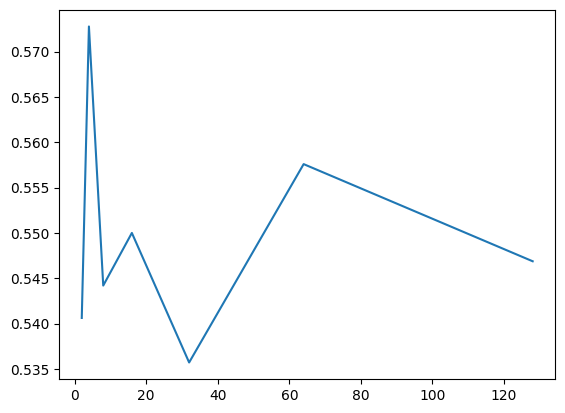

In [204]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
plt_dim=[]
plt_score=[]
for i in range(1,8):
    d=2**i
    X=Graph2VecEmbedding(d,X_train,X_test)
    knn_3 = KNeighborsClassifier(n_neighbors=3)
    scores = cross_val_score(knn_3, X[0], y_train, cv=kfold)
    knn3_score=(sum(scores)/len(scores))
    plt_dim.append(d)
    plt_score.append(knn3_score)
plt.plot(plt_dim,plt_score)
plt.show()

knn cross validation (n=sqrt(n))

In [180]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
plt_dim=[]
plt_score=[]
for i in range(1,8):
    d=2**i
    X=Graph2VecEmbedding(d,X_train,X_test)
    knn_sqrt = KNeighborsClassifier(n_neighbors=math.floor(math.sqrt(N)))
    scores = cross_val_score(knn_sqrt, X[0], y_train, cv=kfold)
    knnSqrt_score=(sum(scores)/len(scores))
    plt_dim.append(d)
    plt_score.append(knnSqrt_score)
plt.plot(plt_dim,plt_score)
plt.show()

0.5589285714285714


Final KNN Model

In [213]:

X=Graph2VecEmbedding(4,X_train,X_test)
knn = KNeighborsClassifier(3)
knn.fit(X[0],y_train)
y_pred = knn.predict(X[1])
accuracy = accuracy_score(y_test, y_pred)

KeyboardInterrupt: 

Accuracy: 0.5357142857142857
[0.60606061 0.43478261]


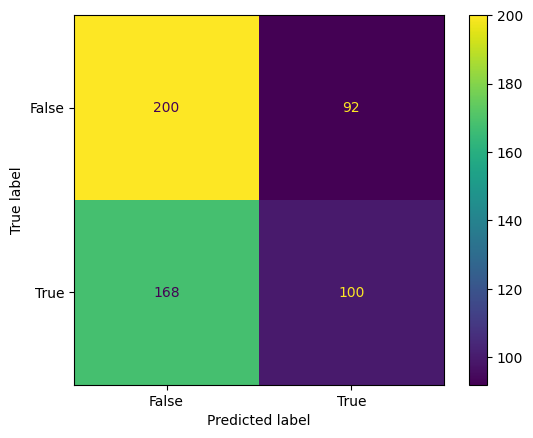

In [212]:
print("Accuracy:", accuracy)
print(f1_score(y_test, y_pred, average=None))
ConfusionMatrixDisplay.from_estimator(knn, X[1], y_test)
plt.show()


RANDOM FOREST WITH GRAPH2VEC

Cross Validation


In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
plt_dim=[]
plt_score=[]
for i in range(1,8):
    d=2**i
    X=Graph2VecEmbedding(d,X_train,X_test)
    random_forest= RandomForestClassifier()
    scores = cross_val_score(random_forest, X[0], y_train, cv=kfold)
    RandomForest_score=(sum(scores)/len(scores))
    plt_dim.append(d)
    plt_score.append(RandomForest_score)
plt.plot(plt_dim,plt_score)
plt.show()

Final Model

In [215]:
X=Graph2VecEmbedding(4,X_train,X_test)
random_forest= RandomForestClassifier()
random_forest.fit(X[0],y_train)
y_pred = random_forest.predict(X[1])
accuracy = accuracy_score(y_test, y_pred)

Accuracy: 0.5875
[0.6407465  0.51572327]


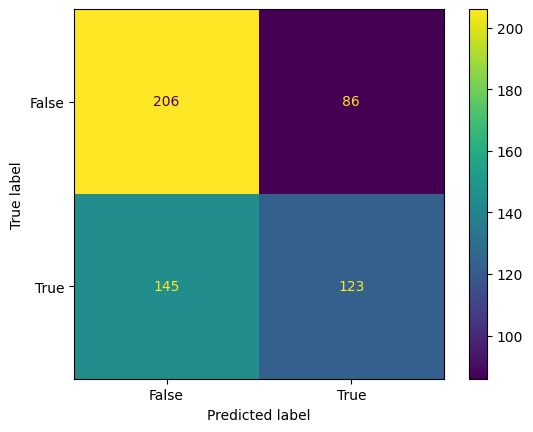

In [216]:
print("Accuracy:", accuracy)
print(f1_score(y_test, y_pred, average=None))
ConfusionMatrixDisplay.from_estimator(random_forest, X[1], y_test)
plt.show()

RANDOM FOREST WITH FEATHER GRAPH

In [218]:
X=FeatherEmbedding(5,X_train,X_test)
random_forest= RandomForestClassifier()
random_forest.fit(X[0],y_train)
y_pred = random_forest.predict(X[1])
accuracy = accuracy_score(y_test, y_pred)

Accuracy: 0.5642857142857143
[0.61146497 0.50406504]


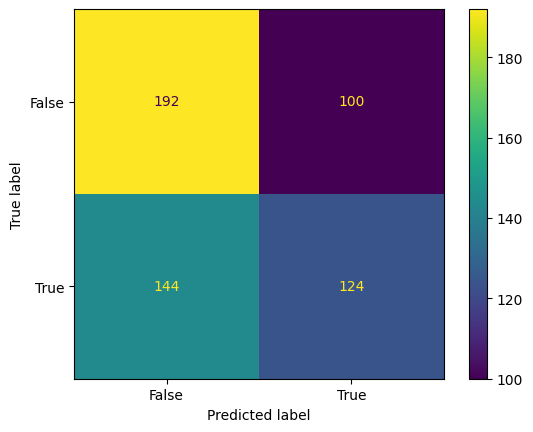

In [220]:
print("Accuracy:", accuracy)
print(f1_score(y_test, y_pred, average=None))
ConfusionMatrixDisplay.from_estimator(random_forest, X[1], y_test)
plt.show()


Cross Validation

In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
plt_dim=[]
plt_score=[]
for i in range(4,16):
    X=FeatherEmbedding(i,X_train,X_test)
    random_forest= RandomForestClassifier()
    scores = cross_val_score(random_forest, X[0], y_train, cv=kfold)
    RandomForest_score=(sum(scores)/len(scores))
    plt_dim.append(d)
    plt_score.append(RandomForest_score)
plt.plot(plt_dim,plt_score)
plt.show()